In [34]:
import pandas as pd
import numpy as np
import time
from pycaret.classification import *

In [62]:
def check_class_ratio(dataset):
    class_ratio = round(np.mean(dataset.circ_next_12h), 2)
    return class_ratio

def random_split_stay(df, train_ratio, Threshold, n_trial):
    data = df.copy()
    
    search_time = time.time()
    
    for T in range(n_trial):
        array = data.subject_id.unique()
        
        # seed = np.random.randint(0, 10000, 1)
        seed = 3582
        np.random.seed(seed) 
        np.random.shuffle(array)


        split_point = int(train_ratio * len(array))
        stay_for_train, stay_for_test = np.split(array, [split_point])

        

        condition_train = data.subject_id.isin(stay_for_train)
        holdout_train = data[condition_train]

        condition_test = data.subject_id.isin(stay_for_test)
        holdout_test = data[condition_test]
        
        # holdout_test = holdout_test.sort_values(by=['subject_id',  'stay_id', 'Time_since_ICU_admission']) 
        # holdout_train = holdout_train.sort_values(by=['subject_id',  'stay_id', 'Time_since_ICU_admission']) 

        train_class_ratio  = check_class_ratio(holdout_train)
        test_class_ratio  = check_class_ratio(holdout_test)
                
            
        if (train_class_ratio - test_class_ratio) >= Threshold:
            
            break  # 클래스 비율이 모두 threshold 이상일 경우 반복문 종료
        
        if T % 100 == 0:
            print('Trial: ', T)
            
        if T % 10000 == 0:
        
            Threshold = Threshold + 0.05
            print('Threshold 조정 + 0.05, 현재 한계값: {}'.format(Threshold))
        
        if T == 9999:
            print('최대 Trial 달성, 분할 불가')
        
    train = holdout_train.copy()
    test = holdout_test.copy()
    search_time_end = time.time()
    
    trn_class1 = train.circ_next_12h.value_counts()[0]
    trn_class2 = train.circ_next_12h.value_counts()[1]
    
    tes_class1 = test.circ_next_12h.value_counts()[0]
    tes_class2 = test.circ_next_12h.value_counts()[1]

    
    
    print('train set : test set = {} : {}'.format(train_ratio, 1-train_ratio))
    print('Train set class: ', train.circ_next_12h.value_counts().sort_index())
    print('Test set class: ', test.circ_next_12h.value_counts().sort_index())
    print('-'*20)
    print('Train class ratio: {}:{}'.format((trn_class1)/(trn_class1+trn_class2), (trn_class2)/(trn_class1+trn_class2)))
    print('Test class ratio: {}:{}'.format((tes_class1)/(tes_class1+tes_class2), (tes_class2)/(tes_class1+tes_class2)))
    print('-'*20)
    print('Number of trainset patient:', len(train.subject_id.unique()))
    print('Number of testset patient:', len(test.subject_id.unique()))
    print('Number of trainset stay:', len(train.stay_id.unique()))
    print('Number of testset stay:', len(test.stay_id.unique()))
    print('-'*20)
    print('Split seed: ',seed)
    print('train ratio:', train_ratio)
    print('Threshold:', Threshold)
    print('-'*20)
    print('총 소요 시간(초):{}'.format(search_time_end - search_time))
    print('시도한 trial 수: ', T)
    
    return train, test, stay_for_train, stay_for_test

In [36]:
dataset = pd.read_csv('/Users/DAHS/MIMIC-IV-Data-Pipeline/MIMIC_pipeline/mimic_df.csv', index_col = 0, compression='gzip')

In [37]:
dataset.replace([np.inf, -np.inf], np.nan, inplace=True)

dataset['pao2/fio2_fillna']=0
idx = dataset[dataset['pao2/fio2'].isnull()].index
dataset['pao2/fio2'].loc[idx]=0
dataset['pao2/fio2_fillna'].loc[idx]=1

In [59]:
mimic_train_ori, mimic_valid_ori, trn_patient, val_patient = random_split_stay(dataset, 0.7, Threshold=0.05, n_trial=1) 

Trial:  0
Threshold 조정 + 0.05, 현재 한계값: 0.1
train set : test set = 0.7 : 0.30000000000000004
Train set class:  0.0    971665
1.0    256070
Name: circ_next_12h, dtype: int64
Test set class:  0.0    431215
1.0    114522
Name: circ_next_12h, dtype: int64
--------------------
Train class ratio: 0.7914289321392646:0.20857106786073543
Test class ratio: 0.7901516664620504:0.2098483335379496
--------------------
Number of trainset patient: 7515
Number of testset patient: 3221
Number of trainset stay: 8381
Number of testset stay: 3596
--------------------
Split seed:  [3582]
train ratio: 0.7
Threshold: 0.1
--------------------
총 소요 시간(초):1.042069435119629
시도한 trial 수:  0


In [7]:
embset = pd.read_csv('/Users/DAHS/MIMIC-IV-Data-Pipeline/MIMIC_pipeline/supervised_contrastive_learning/embedding_data.csv', index_col = 0)
embset = embset.rename(columns ={'184':'classes'})

eep_emb = embset[(embset['classes']==0)|(embset['classes']==1)]

mimic_train_emb, mimic_valid_emb, trn_patient, val_patient = random_split_stay(eep_emb, 0.7, Threshold=0.05, n_trial=1) 
mimic_train_emb = mimic_train_emb.reset_index(drop=True)
mimic_valid_emb = mimic_valid_emb.reset_index(drop=True)

for_feature = mimic_train_ori.drop(['subject_id', 'stay_id', 'hadm_id','Annotation','circ_next_12h', 'classes'], axis = 1)
for_feature_v = mimic_valid_ori.drop(['subject_id', 'stay_id', 'hadm_id','Annotation','circ_next_12h', 'classes'], axis = 1)

# mimic_train_feature = pd.read_csv('augmented_train_df(feature_space).csv', compression='gzip')
mimic_train_feature = pd.concat([for_feature, mimic_train_emb], axis = 1)
mimic_valid_feature = pd.concat([for_feature_v, mimic_valid_emb], axis = 1)

Trial:  0
Threshold 조정 + 0.05, 현재 한계값: 0.1
train set : test set = 0.7 : 0.30000000000000004
Train set class:  0    393779
1     16667
Name: classes, dtype: int64
Test set class:  0    175301
1      6946
Name: classes, dtype: int64
--------------------
Train class ratio: 0.9593929530315802:0.04060704696841972
Test class ratio: 0.9618868897704763:0.03811311022952367
--------------------
Number of trainset patient: 3525
Number of testset patient: 1512
Number of trainset stay: 3749
Number of testset stay: 1617
--------------------
Split seed:  49
train ratio: 0.7
Threshold: 0.1
--------------------
총 소요 시간(초):0.34603238105773926
시도한 trial 수:  0


In [8]:
# original space, circulatory prediction

input_space_clf_setting = setup(data = mimic_train_ori.drop(['Unnamed: 0'], axis = 1), target = 'classes',
                                test_data = mimic_valid_ori.drop(['Unnamed: 0', 'subject_id', 'stay_id', 'hadm_id','Annotation','circ_next_12h'], axis = 1),
                                index=False, session_id = 123, normalize_method='minmax')

,Description,Value
0,Session id,123
1,Target,classes
2,Target type,Binary
3,Original data shape,"(1837745, 172)"
4,Transformed data shape,"(1837745, 172)"
5,Transformed train set shape,"(1506690, 172)"
6,Transformed test set shape,"(331055, 172)"
7,Numeric features,171
8,Preprocess,True
9,Imputation type,simple


In [13]:
best = compare_models(include = ['svm','lr', 'dt', 'lightgbm', 'xgboost'], fold = 5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9592,0.7691,0.0406,0.5148,0.0747,0.0688,0.1340,29.7160
lightgbm,Light Gradient Boosting Machine,0.9581,0.8150,0.1247,0.4515,0.1936,0.1791,0.2200,2.4140
xgboost,Extreme Gradient Boosting,0.9558,0.7895,0.1345,0.3756,0.1966,0.1793,0.2053,3.9660
svm,SVM - Linear Kernel,0.9124,0.0000,0.2122,0.2057,0.1773,0.1411,0.1525,3.9540
dt,Decision Tree Classifier,0.9028,0.5821,0.2331,0.1264,0.1635,0.1169,0.1232,6.8560


In [7]:
best = compare_models(include = ['svm','lr', 'dt', 'lightgbm', 'xgboost'], cross_validation=False)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,01:57:34
Status,. . . . . . . . . . . . . . . . . .,Fitting Decision Tree Classifier
Estimator,. . . . . . . . . . . . . . . . . .,Decision Tree Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.8140,0.6607,0.5007,0.0555,0.0999,0.0652,0.1173,120.8200
lr,Logistic Regression,0.7339,0.7941,0.7020,0.0527,0.0981,0.0621,0.1390,151.7500


Processing:   0%|          | 0/25 [00:00<?, ?it/s]

In [11]:
test_data = mimic_valid_ori.drop(['Unnamed: 0','subject_id', 'stay_id', 'hadm_id'], axis = 1)

In [9]:
lightgbm = create_model('lightgbm', cross_validation=False, learning_rate=0.1)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.9638,0.8064,0.1847,0.1641,0.1738,0.1553,0.1556


In [12]:
pred_df = predict_model(lightgbm, data=test_data, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9638,0.8064,0.1847,0.1641,0.1738,0.1553,0.1556


In [17]:
mimic_valid_ori[mimic_valid_ori['classes']==1].stay_id.unique()

array([30009505, 30020307, 30044183, 30056766, 30058023, 30085141,
       30089953, 30105012, 30129184, 30144893, 30148826, 30165909,
       30225882, 30230188, 30243071, 30250677, 30252361, 30252876,
       30268314, 30272018, 30275792, 30303103, 30326687, 30372280,
       30407507, 30413099, 30443314, 30465394, 30465776, 30479204,
       30482528, 30488733, 30495523, 30553761, 30556129, 30560022,
       30578491, 30599577, 30600396, 30601518, 30614382, 30632193,
       30647767, 30651352, 30665877, 30708785, 30736190, 30742542,
       30747951, 30748248, 30748328, 30774146, 30774935, 30782963,
       30792655, 30794184, 30797241, 30824092, 30831346, 30832709,
       30863184, 30864103, 30887836, 30893431, 30932571, 30932864,
       30944700, 30958024, 30969402, 30970201, 30980315, 30985065,
       30988867, 31022069, 31023101, 31028809, 31043200, 31053840,
       31077698, 31080524, 31087546, 31090802, 31132134, 31200927,
       31223532, 31239019, 31240612, 31246375, 31277766, 31285

In [33]:
dataset[dataset['stay_id']==30495523][['Time_since_ICU_admission','Annotation','circ_next_12h','classes']]

,Time_since_ICU_admission,Annotation,circ_next_12h,classes
109211,0,no_circ,1,1
109212,1,no_circ,1,1
109213,2,no_circ,1,1
109214,3,no_circ,1,1
109215,4,no_circ,1,1
109216,5,no_circ,1,1
109220,9,circ,1,3
109221,10,circ,1,3
109222,11,circ,1,3
109223,12,circ,1,3


In [ ]:
def calculate_cap_recall(df):
    # find circ event and that time
    circ_events = df[df['Annotation'] == 'circ']['Time_since_ICU_admission'].tolist()
    captured_events = 0

    for event_time in circ_events:
        # circ 이벤트 이전의 12시간 동안의 관측치를 탐색
        previous_times = df[(df['Time_since_ICU_admission'] >= event_time - 12) & (df['Time_since_ICU_admission'] < event_time)]
        
        # 이 중에서 예측 레이블이 1인 경우가 하나라도 있는지 확인
        if any(previous_times['prediction_label'] == 1):
            captured_events += 1

    # 전체 circ 이벤트 중에서 capture한 비율을 계산
    cap_recall = captured_events / len(circ_events) if circ_events else 0
    return cap_recall

cap_recall = calculate_cap_recall(df)
cap_recall

In [24]:
mimic_valid_ori[mimic_valid_ori['stay_id']==30495523][['Time_since_ICU_admission','Annotation', 'classes']]

,Time_since_ICU_admission,Annotation,classes
18051,0,no_circ,1
18052,1,no_circ,1
18053,2,no_circ,1
18054,3,no_circ,1
18055,4,no_circ,1
18056,5,no_circ,1


In [26]:
pred_df[['Annotation', 'circ_next_12h', 'classes', 'prediction_label']].iloc[18051:18056]

,Annotation,circ_next_12h,classes,prediction_label
18051,no_circ,1,1,1
18052,no_circ,1,1,0
18053,no_circ,1,1,0
18054,no_circ,1,1,0
18055,no_circ,1,1,0


In [72]:
dt = create_model('dt', cross_validation=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.8547,0.6720,0.4383,0.3622,0.3966,0.3149,0.3168


In [73]:
xgboost = create_model('xgboost', cross_validation=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.9039,0.8997,0.4491,0.5753,0.5044,0.4521,0.4563


In [74]:
lr = create_model('lr', cross_validation=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.8963,0.8596,0.2990,0.5433,0.3857,0.3342,0.3521


In [75]:
svm = create_model('svm', cross_validation=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.8668,0.6436,0.3581,0.3814,0.3694,0.2950,0.2952


In [27]:
predictions_1_o = predict_model(lightgbm, data=test_data, raw_score=True)
predictions_2_o = predict_model(dt, data=test_data, raw_score=True)
predictions_3_o = predict_model(xgboost, data=test_data, raw_score=True)
predictions_4_o = predict_model(lr, data=test_data, raw_score=True)
predictions_5_o = predict_model(svm, data=test_data, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9476,0.8310,0.2673,0.2942,0.2801,0.2530,0.2533


NameError: name 'dt' is not defined

In [331]:
lgbmioc = IoC(precision=0.5797, recall=0.4173, beta= 2)
lrioc = IoC(precision=0.5405, recall=0.2962, beta= 2)
xgbioc = IoC(precision=0.5275, recall=0.4271, beta= 2)
dtioc = IoC(precision=0.3622, recall=0.4383, beta= 2)
svmioc = IoC(precision=0.2789, recall=0.6275, beta= 2)

print('ioc(beta=2)')
print('light gbm: ', lgbmioc)
print('dtL ', dtioc)
print('xgbioc', xgbioc)
print('lrioc', lrioc)
print('svmioc', svmioc)

ioc(beta=2)
light gbm:  0.44206865611637
dtL  0.4206249271368767
xgbioc 0.4440015174805881
lrioc 0.32563684810023596
svmioc 0.502007199816419


In [363]:
(lgbmioc + dtioc + xgbioc + lrioc + svmioc)/5

0.4268678297300979

In [332]:
lgbmioc15 = IoC(precision=0.5797, recall=0.4173, beta= 1.5)
lrioc15 = IoC(precision=0.5405, recall=0.2962, beta= 1.5)
xgbioc15 = IoC(precision=0.5275, recall=0.4271, beta= 1.5)
dtioc15 = IoC(precision=0.3622, recall=0.4383, beta= 1.5)
svmioc15 = IoC(precision=0.2789, recall=0.6275, beta= 1.5)

In [333]:
print('ioc(beta=2)')
print('light gbm: ', lgbmioc15)
print('dtL ', dtioc15)
print('xgbioc', xgbioc15)
print('lrioc', lrioc15)
print('svmioc', svmioc15)

ioc(beta=2)
light gbm:  0.4566636941842736
dtL  0.41168549371633756
xgbioc 0.4536684660543069
lrioc 0.34404795596184684
svmioc 0.4532034720423896


In [15]:
# feature space
feature_space_clf_setting = setup(data = mimic_train_feature.drop(['Unnamed: 0'], axis = 1), target = 'classes',
                                test_data = mimic_valid_feature.drop(['Unnamed: 0'], axis = 1), index=False, session_id = 123)

,Description,Value
0,Session id,123
1,Target,classes
2,Target type,Binary
3,Original data shape,"(969805, 407)"
4,Transformed data shape,"(969805, 407)"
5,Transformed train set shape,"(787558, 407)"
6,Transformed test set shape,"(182247, 407)"
7,Numeric features,406
8,Preprocess,True
9,Imputation type,simple


In [40]:
test_data = mimic_valid_feature.drop(['subject_id', 'stay_id', 'hadm_id'], axis = 1)

In [16]:
best = compare_models(include = ['svm','lr', 'dt', 'lightgbm', 'xgboost'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.8435,0.8435,0.9939,0.8022,0.8793,0.6870,0.7012,60.0330
lightgbm,Light Gradient Boosting Machine,0.8410,0.8823,0.9654,0.8127,0.8755,0.6820,0.6795,16.5280
xgboost,Extreme Gradient Boosting,0.7554,0.9108,0.9681,0.6985,0.8075,0.5108,0.5416,17.3400
svm,SVM - Linear Kernel,0.5031,0.0000,0.2856,0.1519,0.1979,0.0062,0.0081,99.1350
lr,Logistic Regression,0.4633,0.4468,0.6141,0.4733,0.5285,-0.0733,-0.0784,8.8640


In [20]:
lightgbm = create_model('lightgbm', cross_validation=False, learning_rate=0.1)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.9036,0.9060,0.4173,0.5797,0.4852,0.4336,0.4407


In [24]:
dt = create_model('dt', cross_validation=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.8547,0.6720,0.4383,0.3622,0.3966,0.3149,0.3168


In [26]:
xgboost = create_model('xgboost', cross_validation=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.9039,0.8997,0.4491,0.5753,0.5044,0.4521,0.4563


In [29]:
lr = create_model('lr', cross_validation=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.8963,0.8596,0.2990,0.5433,0.3857,0.3342,0.3521


In [32]:
svm = create_model('svm', cross_validation=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.8668,0.6436,0.3581,0.3814,0.3694,0.2950,0.2952


In [22]:
adjust_threshold_lightgbm = create_model('lightgbm', cross_validation=False, learning_rate=0.1, probability_threshold = 0.42)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.8991,0.9060,0.5093,0.5390,0.5238,0.4674,0.4676


In [28]:
adjust_threshold_xgboost = create_model('xgboost', cross_validation=False, probability_threshold = 0.44)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.9005,0.8997,0.4842,0.5493,0.5147,0.4595,0.4606


In [31]:
adjust_threshold_lr = create_model('lr', cross_validation=False, probability_threshold = 0.22)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.8663,0.8596,0.6078,0.4211,0.4975,0.4233,0.4328


In [34]:
information = mimic_valid_ori[['subject_id','Age','gender','ethnicity','insurance', 'Time_since_ICU_admission']]

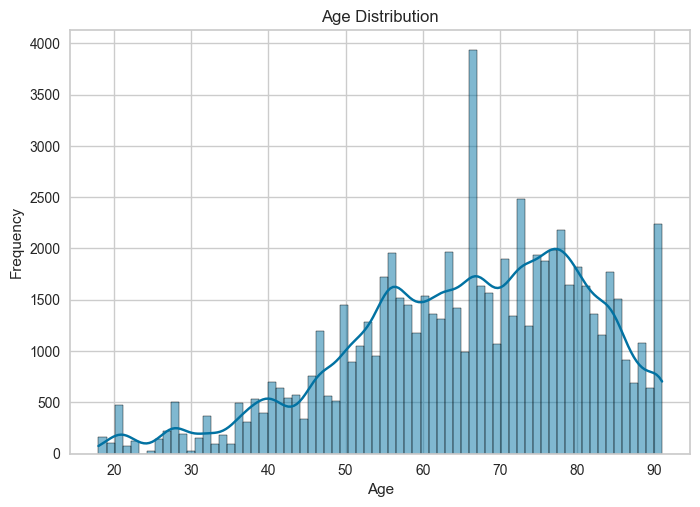

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data=information, x='Age', kde=True)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()

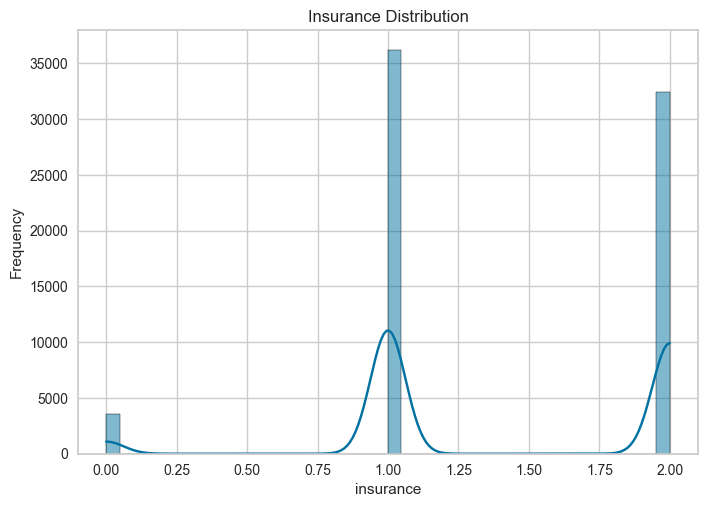

In [38]:
sns.histplot(data=information, x='insurance', kde=True)
plt.xlabel('insurance')
plt.ylabel('Frequency')
plt.title('Insurance Distribution')
plt.show()

In [39]:
import pandas as pd

# 나이를 10년 단위로 그룹화
age_groups = pd.cut(information['Age'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=['0-10', '18-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100'])

# 'Age_Group' 열을 데이터프레임에 추가
information['Age_Group'] = age_groups

In [41]:
predictions_1 = predict_model(adjust_threshold_lightgbm, data=test_data, raw_score=True)
predictions_2 = predict_model(dt, data=test_data, raw_score=True)
predictions_3 = predict_model(adjust_threshold_xgboost, data=test_data, raw_score=True)
predictions_4 = predict_model(adjust_threshold_lr, data=test_data, raw_score=True)
predictions_5 = predict_model(svm, data=test_data, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8991,0.9060,0.5093,0.5390,0.5238,0.4674,0.4676


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.8547,0.6720,0.4383,0.3622,0.3966,0.3149,0.3168


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9005,0.8997,0.4842,0.5493,0.5147,0.4595,0.4606


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8663,0.8596,0.6078,0.4211,0.4975,0.4233,0.4328


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.8668,0.6436,0.3581,0.3814,0.3694,0.2950,0.2952


In [42]:
def make_mapper(predictions):    
    #AGE
    age = information[['subject_id', 'Age_Group']]
    dict_age = age.set_index('subject_id')['Age_Group'].to_dict()

    predictions['Age_Group'] = mimic_valid_ori['subject_id'].values.copy()
    predictions['Age_Group']  = predictions['Age_Group'].map(dict_age)

    #Insurance
    insurance = information[['subject_id', 'insurance']]
    dict_ins = insurance.set_index('subject_id')['insurance'].to_dict()

    predictions['insurance_Group'] = mimic_valid_ori['subject_id'].values.copy()
    predictions['insurance_Group']  = predictions['insurance_Group'].map(dict_ins)

    #Gender
    gender = information[['subject_id', 'gender']]
    dict_gender = gender.set_index('subject_id')['gender'].to_dict()

    predictions['gender_Group'] = mimic_valid_ori['subject_id'].values.copy()
    predictions['gender_Group']  = predictions['gender_Group'].map(dict_gender)

    #Ethnicity
    ethnicity = information[['subject_id', 'ethnicity']]
    dict_ethnicity = ethnicity.set_index('subject_id')['ethnicity'].to_dict()

    predictions['ethnicity_Group'] = mimic_valid_ori['subject_id'].values.copy()
    predictions['ethnicity_Group']  = predictions['ethnicity_Group'].map(dict_ethnicity)
    
    return predictions

In [43]:
predictions_1 = make_mapper(predictions_1)
predictions_2 = make_mapper(predictions_2)
predictions_3 = make_mapper(predictions_3)
predictions_4 = make_mapper(predictions_4)
predictions_5 = make_mapper(predictions_5)

In [44]:
ethnicities = ['AMERICAN INDIAN/ALASKA NATIVE', 'ASIAN', 'ASIAN - ASIAN INDIAN',
    'ASIAN - CHINESE', 'ASIAN - KOREAN', 'ASIAN - SOUTH EAST ASIAN',
    'BLACK/AFRICAN', 'BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN',
    'BLACK/CARIBBEAN ISLAND', 'HISPANIC OR LATINO',
    'HISPANIC/LATINO - CENTRAL AMERICAN', 'HISPANIC/LATINO - COLUMBIAN',
    'HISPANIC/LATINO - CUBAN', 'HISPANIC/LATINO - DOMINICAN',
    'HISPANIC/LATINO - GUATEMALAN', 'HISPANIC/LATINO - HONDURAN',
    'HISPANIC/LATINO - MEXICAN', 'HISPANIC/LATINO - PUERTO RICAN',
    'HISPANIC/LATINO - SALVADORAN', 'MULTIPLE RACE/ETHNICITY',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'OTHER',
    'PATIENT DECLINED TO ANSWER', 'PORTUGUESE', 'SOUTH AMERICAN',
    'UNABLE TO OBTAIN', 'UNKNOWN', 'WHITE', 'WHITE - BRAZILIAN',
    'WHITE - EASTERN EUROPEAN', 'WHITE - OTHER EUROPEAN', 'WHITE - RUSSIAN'
]

ethnicity_dict = {idx: ethnicity for idx, ethnicity in enumerate(ethnicities)}

insurance = ['Medicaid', 'Medicare', 'Other']
insurance_dict = {idx: ins for idx, ins in enumerate(insurance)}

form  = ['Female', 'Male']
gen_dict = {idx: gen for idx, gen in enumerate(form)}


def group_mapper(predictions):

    predictions['gender_Group']  = predictions['gender_Group'].map(gen_dict)
    predictions['insurance_Group']  = predictions['insurance_Group'].map(insurance_dict)
    predictions['ethnicity_Group']  = predictions['ethnicity_Group'].map(ethnicity_dict)
    
    return predictions

predictions_1 = group_mapper(predictions_1)
predictions_2 = group_mapper(predictions_2)
predictions_3 = group_mapper(predictions_3)
predictions_4 = group_mapper(predictions_4)
predictions_5 = group_mapper(predictions_5)

In [45]:
def IoC(precision, recall, beta):
    score = (1+beta**2)*precision*recall/((beta**2)*precision+recall)
    return score

In [46]:
lgbmioc = IoC(precision=0.539, recall=0.5093, beta= 2)
dtioc = IoC(precision=0.3622, recall=0.4383, beta= 2)
xgbioc = IoC(precision=0.5493, recall=0.4842, beta= 2)
lrioc = IoC(precision=0.4211, recall=0.6078, beta= 2)
svmioc = IoC(precision=0.3841, recall=0.3581, beta= 2)

In [47]:
print('ioc(beta=2)')
print('light gbm: ', lgbmioc)
print('dtL ', dtioc)
print('xgbioc', xgbioc)
print('lrioc', lrioc)
print('svmioc', svmioc)

ioc(beta=2)
light gbm:  0.5149752373091209
dtL  0.4206249271368767
xgbioc 0.49595558290445296
lrioc 0.5582946078003664
svmioc 0.36301454209553974


In [48]:
lgbmioc_1 = IoC(precision=0.539, recall=0.5093, beta= 1.5)
dtioc_1 = IoC(precision=0.3622, recall=0.4383, beta= 1.5)
xgbioc_1 = IoC(precision=0.5493, recall=0.4842, beta= 1.5)
lrioc_1 = IoC(precision=0.4211, recall=0.6078, beta= 1.5)
svmioc_1 = IoC(precision=0.3841, recall=0.3581, beta= 1.5)

In [49]:
print('ioc(beta=1.5)')
print('light gbm: ', lgbmioc)
print('dtL ', dtioc)
print('xgbioc', xgbioc)
print('lrioc', lrioc)
print('svmioc', svmioc)

ioc(beta=1.5)
light gbm:  0.5149752373091209
dtL  0.4206249271368767
xgbioc 0.49595558290445296
lrioc 0.5582946078003664
svmioc 0.36301454209553974


In [50]:
(lgbmioc + dtioc + xgbioc + lrioc + svmioc)/5

0.47057297944927134

In [51]:
predictions_model1 = predictions_1.copy()
predictions_model2 = predictions_2.copy()
predictions_model3 = predictions_3.copy()
predictions_model4 = predictions_4.copy()
predictions_model5 = predictions_5.copy()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


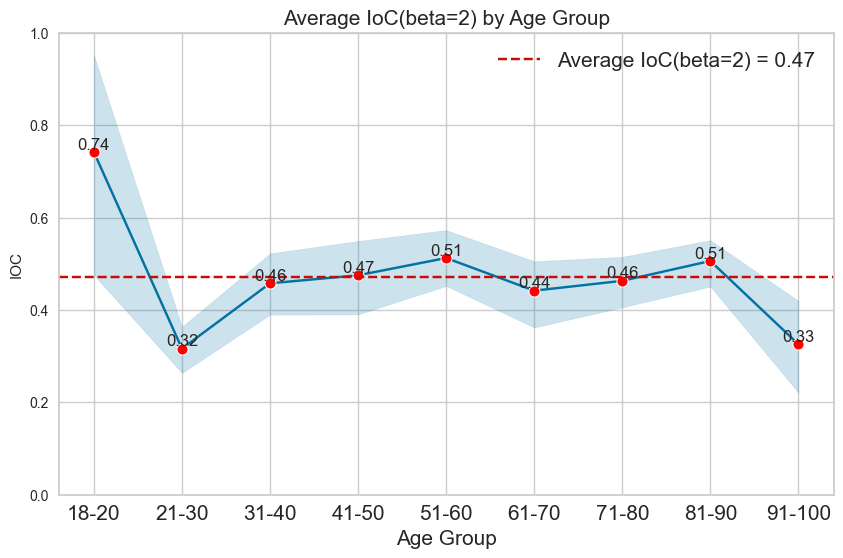

In [52]:
from sklearn.metrics import recall_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt

predictions_model1 = predictions_1.copy()
predictions_model2 = predictions_2.copy()
predictions_model3 = predictions_3.copy()
predictions_model4 = predictions_4.copy()
predictions_model5 = predictions_5.copy()

# 각 모델의 예측 결과를 저장하는 데이터프레임 목록 생성
model_predictions = [predictions_model1, predictions_model2, predictions_model3, predictions_model4, predictions_model5]
model_names = ['lgbm', 'dt', 'xgboost', 'lr', 'svm']

# 빈 리스트를 만들어 나이 그룹과 해당 그룹의 IOC 값을 저장
age_groups = []
IOC_scores = []
model_labels = []

# 모델 목록을 반복하면서 각 모델에 대한 성능 메트릭 계산
for model_name, predictions in zip(model_names, model_predictions):
    data = predictions[['classes', 'prediction_label', 'Age_Group']]
    unique_age_groups = data['Age_Group'].unique()
    unique_age_groups = sorted(unique_age_groups)
    
    for age_group in unique_age_groups:
        subset = data[data['Age_Group'] == age_group]
        recall = recall_score(subset['classes'], subset['prediction_label'])
        precision = precision_score(subset['classes'], subset['prediction_label'])
        ioc = IoC(precision, recall, 2)
        age_groups.append(age_group)
        IOC_scores.append(ioc)
        model_labels.append(model_name)

# 데이터프레임으로 변환
data = pd.DataFrame({'Age_Group': age_groups, 'IOC': IOC_scores, 'Model': model_labels})

# 그래프 그리기 (포인트 플롯)
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='Age_Group', y='IOC', marker='o', markersize=8, markerfacecolor='red')
plt.xlabel('Age Group', fontsize = 15)
plt.ylabel('IOC')
plt.title('Average IoC(beta=2) by Age Group', fontsize=15)
plt.xticks(rotation=0, fontsize = 15)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='upper right')  # 범례 표시

totalIOC = 0.47057297944927134
plt.axhline(y=totalIOC, color='r', linestyle='--', label=f'Average IoC(beta=2) = {totalIOC:.2f}')
plt.legend(loc='upper right', fontsize = 15)  # 범례 표시
# 각 그룹별로 IOC의 평균값을 계산하고 노출
average_ioc = data.groupby(['Age_Group'])['IOC'].mean().reset_index()
for i, row in average_ioc.iterrows():
    x_position = unique_age_groups.index(row['Age_Group'])
    plt.text(x_position, row['IOC'], f"{row['IOC']:.2f}", ha='center', va='bottom')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


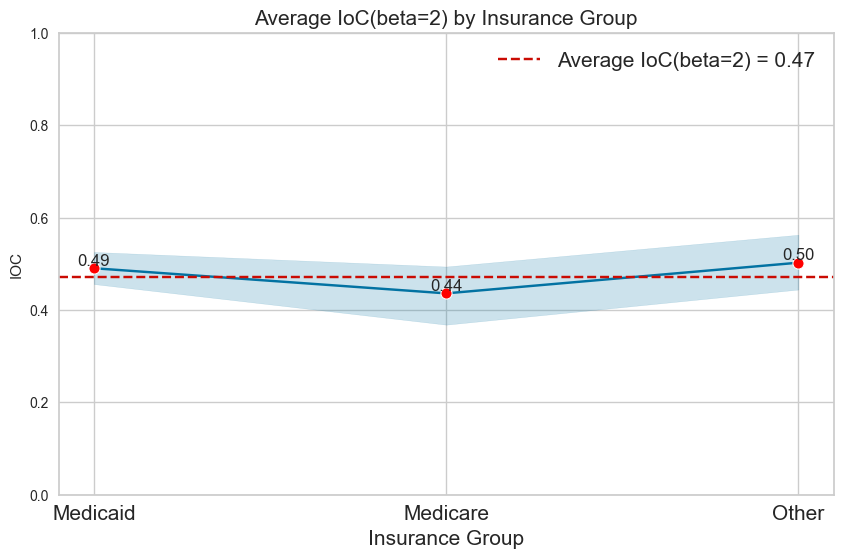

In [53]:
#insurance_Group

predictions_model1 = predictions_1.copy()
predictions_model2 = predictions_2.copy()
predictions_model3 = predictions_3.copy()
predictions_model4 = predictions_4.copy()
predictions_model5 = predictions_5.copy()

# 각 모델의 예측 결과를 저장하는 데이터프레임 목록 생성
model_predictions = [predictions_model1, predictions_model2, predictions_model3, predictions_model4, predictions_model5]
model_names = ['lgbm', 'dt', 'xgboost', 'lr', 'svm']

# 빈 리스트를 만들어 나이 그룹과 해당 그룹의 IOC 값을 저장
age_groups = []
IOC_scores = []
model_labels = []

# 모델 목록을 반복하면서 각 모델에 대한 성능 메트릭 계산
for model_name, predictions in zip(model_names, model_predictions):
    data = predictions[['classes', 'prediction_label', 'insurance_Group']]
    unique_age_groups = data['insurance_Group'].unique()
    unique_age_groups = sorted(unique_age_groups)
    
    for age_group in unique_age_groups:
        subset = data[data['insurance_Group'] == age_group]
        recall = recall_score(subset['classes'], subset['prediction_label'])
        precision = precision_score(subset['classes'], subset['prediction_label'])
        ioc = IoC(precision, recall, 2)
        age_groups.append(age_group)
        IOC_scores.append(ioc)
        model_labels.append(model_name)

# 데이터프레임으로 변환
data = pd.DataFrame({'insurance_Group': age_groups, 'IOC': IOC_scores, 'Model': model_labels})

# 그래프 그리기 (포인트 플롯)
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='insurance_Group', y='IOC', marker='o', markersize=8, markerfacecolor='red')
plt.xlabel('Insurance Group', fontsize=15)
plt.ylabel('IOC')
plt.title('Average IoC(beta=2) by Insurance Group', fontsize=15)
plt.xticks(rotation=0, fontsize=15)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='upper right', fontsize=15)  # 범례 표시

totalIOC = 0.47057297944927134
plt.axhline(y=totalIOC, color='r', linestyle='--', label=f'Average IoC(beta=2) = {totalIOC:.2f}')
plt.legend(loc='upper right', fontsize=15)  # 범례 표시
# 각 그룹별로 IOC의 평균값을 계산하고 노출
average_ioc = data.groupby(['insurance_Group'])['IOC'].mean().reset_index()
for i, row in average_ioc.iterrows():
    x_position = unique_age_groups.index(row['insurance_Group'])
    plt.text(x_position, row['IOC'], f"{row['IOC']:.2f}", ha='center', va='bottom')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


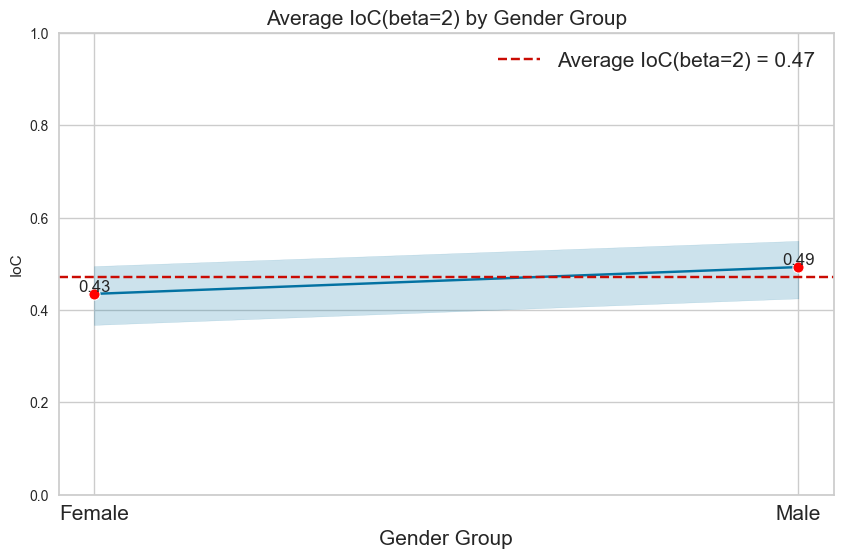

In [54]:
#gender_Group

predictions_model1 = predictions_1.copy()
predictions_model2 = predictions_2.copy()
predictions_model3 = predictions_3.copy()
predictions_model4 = predictions_4.copy()
predictions_model5 = predictions_5.copy()

# 각 모델의 예측 결과를 저장하는 데이터프레임 목록 생성
model_predictions = [predictions_model1, predictions_model2, predictions_model3, predictions_model4, predictions_model5]
model_names = ['lgbm', 'dt', 'xgboost', 'lr', 'svm']

# 빈 리스트를 만들어 나이 그룹과 해당 그룹의 IOC 값을 저장
age_groups = []
IOC_scores = []
model_labels = []

# 모델 목록을 반복하면서 각 모델에 대한 성능 메트릭 계산
for model_name, predictions in zip(model_names, model_predictions):
    data = predictions[['classes', 'prediction_label', 'gender_Group']]
    unique_age_groups = data['gender_Group'].unique()
    unique_age_groups = sorted(unique_age_groups)
    
    for age_group in unique_age_groups:
        subset = data[data['gender_Group'] == age_group]
        recall = recall_score(subset['classes'], subset['prediction_label'])
        precision = precision_score(subset['classes'], subset['prediction_label'])
        ioc = IoC(precision, recall, 2)
        age_groups.append(age_group)
        IOC_scores.append(ioc)
        model_labels.append(model_name)

# 데이터프레임으로 변환
data = pd.DataFrame({'gender_Group': age_groups, 'IOC': IOC_scores, 'Model': model_labels})

# 그래프 그리기 (포인트 플롯)
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='gender_Group', y='IOC', marker='o', markersize=8, markerfacecolor='red')
plt.xlabel('Gender Group', fontsize=15)
plt.ylabel('IoC')
plt.title('Average IoC(beta=2) by Gender Group', fontsize=15)
plt.xticks(rotation=0, fontsize=15)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='upper right')  # 범례 표시

totalIOC = 0.47057297944927134
plt.axhline(y=totalIOC, color='r', linestyle='--', label=f'Average IoC(beta=2) = {totalIOC:.2f}')
plt.legend(loc='upper right', fontsize= 15)  # 범례 표시
# 각 그룹별로 IOC의 평균값을 계산하고 노출
average_ioc = data.groupby(['gender_Group'])['IOC'].mean().reset_index()
for i, row in average_ioc.iterrows():
    x_position = unique_age_groups.index(row['gender_Group'])
    plt.text(x_position, row['IOC'], f"{row['IOC']:.2f}", ha='center', va='bottom')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
posx and posy should be finite values
posx and posy should be finite values


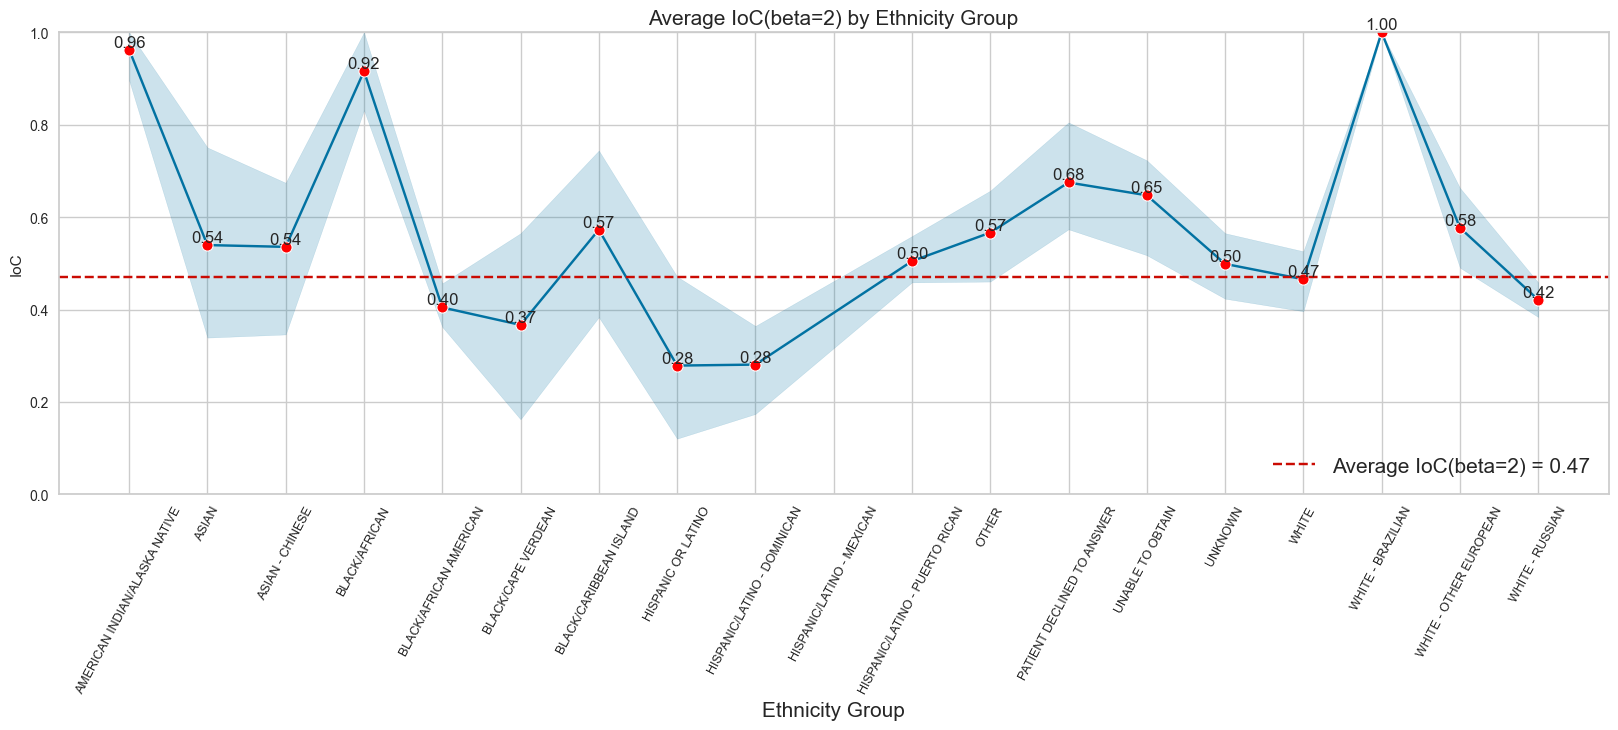

In [55]:
predictions_model1 = predictions_1.copy()
predictions_model2 = predictions_2.copy()
predictions_model3 = predictions_3.copy()
predictions_model4 = predictions_4.copy()
predictions_model5 = predictions_5.copy()

# 각 모델의 예측 결과를 저장하는 데이터프레임 목록 생성
model_predictions = [predictions_model1, predictions_model2, predictions_model3, predictions_model4, predictions_model5]
model_names = ['lgbm', 'dt', 'xgboost', 'lr', 'svm']

# 빈 리스트를 만들어 나이 그룹과 해당 그룹의 IOC 값을 저장
age_groups = []
IOC_scores = []
model_labels = []

# 모델 목록을 반복하면서 각 모델에 대한 성능 메트릭 계산
for model_name, predictions in zip(model_names, model_predictions):
    data = predictions[['classes', 'prediction_label', 'ethnicity_Group']]
    unique_age_groups = ['AMERICAN INDIAN/ALASKA NATIVE', 'ASIAN', 'ASIAN - CHINESE',
       'BLACK/AFRICAN', 'BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN',
       'BLACK/CARIBBEAN ISLAND', 'HISPANIC OR LATINO',
       'HISPANIC/LATINO - DOMINICAN', 'HISPANIC/LATINO - MEXICAN',
       'HISPANIC/LATINO - PUERTO RICAN', 'OTHER',
       'PATIENT DECLINED TO ANSWER', 'UNABLE TO OBTAIN', 'UNKNOWN',
       'WHITE', 'WHITE - BRAZILIAN', 'WHITE - OTHER EUROPEAN',
       'WHITE - RUSSIAN']
    unique_age_groups = sorted(unique_age_groups)
    
    for age_group in unique_age_groups:
        subset = data[data['ethnicity_Group'] == age_group]
        recall = recall_score(subset['classes'], subset['prediction_label'])
        precision = precision_score(subset['classes'], subset['prediction_label'])
        ioc = IoC(precision, recall, 2)
        age_groups.append(age_group)
        IOC_scores.append(ioc)
        model_labels.append(model_name)

# 데이터프레임으로 변환
data = pd.DataFrame({'ethnicity_Group': age_groups, 'IOC': IOC_scores, 'Model': model_labels})
plt.figure(figsize=(20, 6))
# 그래프 그리기 (포인트 플롯)
sns.lineplot(data=data, x='ethnicity_Group', y='IOC', marker='o', markersize=8, markerfacecolor='red')
plt.xlabel('Ethnicity Group',fontsize=15)
plt.ylabel('IoC')
plt.title('Average IoC(beta=2) by Ethnicity Group', fontsize=15)
plt.xticks(rotation=62,fontsize=9)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='upper right')  # 범례 표시

# totalIOC = 0.47769309537780436
plt.axhline(y=totalIOC, color='r', linestyle='--', label=f'Average IoC(beta=2) = {totalIOC:.2f}')
plt.legend(loc='lower right', fontsize=15)  # 범례 표시
# 각 그룹별로 IOC의 평균값을 계산하고 노출
average_ioc = data.groupby(['ethnicity_Group'])['IOC'].mean().reset_index()
for i, row in average_ioc.iterrows():
    x_position = unique_age_groups.index(row['ethnicity_Group'])
    plt.text(x_position, row['IOC'], f"{row['IOC']:.2f}", ha='center', va='bottom')

plt.show()

In [56]:
# 나이를 10년 단위로 그룹화
time_groups = pd.cut(information['Time_since_ICU_admission'], bins=[0, 1, 2, 4, 8, 24, 48, 71.5], labels=['1h', '2h', '4h', '8h', '24h', '2d', '3d~'])
# time_groups = pd.cut(information['Time_since_ICU_admission'], bins=[0, 1, 2, 4, 8, 24, 48, 71.5], labels=['1h', '2h', '4h', '8h', '24h', '2d~'])

# 'Age_Group' 열을 데이터프레임에 추가
information['time_Group'] = time_groups

predictions_model1['time_Group'] = time_groups
predictions_model2['time_Group'] = time_groups
predictions_model3['time_Group'] = time_groups
predictions_model4['time_Group'] = time_groups
predictions_model5['time_Group'] = time_groups

In [ ]:
unique_time_groups = ['1h', '2h', '4h', '8h', '24h', '2d', '3d~']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


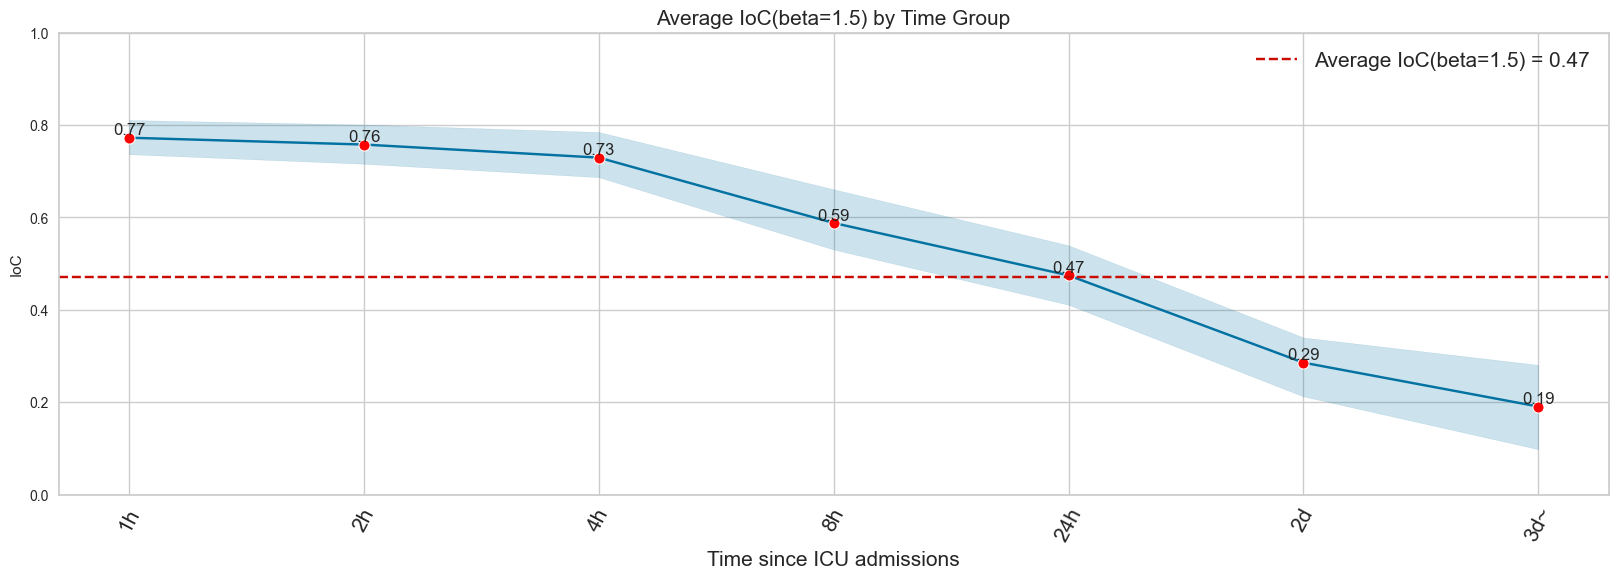

In [57]:
# predictions_model1 = predictions_1.copy()
# predictions_model2 = predictions_2.copy()
# predictions_model3 = predictions_3.copy()
# predictions_model4 = predictions_4.copy()
# predictions_model5 = predictions_5.copy()

# 각 모델의 예측 결과를 저장하는 데이터프레임 목록 생성
model_predictions = [predictions_model1, predictions_model2, predictions_model3, predictions_model4, predictions_model5]
model_names = ['lgbm', 'dt', 'xgboost', 'lr', 'svm']

# 빈 리스트를 만들어 나이 그룹과 해당 그룹의 IOC 값을 저장
age_groups = []
IOC_scores = []
model_labels = []

# 모델 목록을 반복하면서 각 모델에 대한 성능 메트릭 계산
for model_name, predictions in zip(model_names, model_predictions):
    data = predictions[['classes', 'prediction_label', 'time_Group']]
    unique_age_groups = ['1h', '2h', '4h', '8h', '24h', '2d', '3d~']
    # unique_age_groups = sorted(unique_age_groups)
    
    for age_group in unique_age_groups:
        subset = data[data['time_Group'] == age_group]
        recall = recall_score(subset['classes'], subset['prediction_label'])
        precision = precision_score(subset['classes'], subset['prediction_label'])
        ioc = IoC(precision, recall, 1.5)
        age_groups.append(age_group)
        IOC_scores.append(ioc)
        model_labels.append(model_name)

# 데이터프레임으로 변환
data = pd.DataFrame({'time_Group': age_groups, 'IOC': IOC_scores, 'Model': model_labels})
plt.figure(figsize=(20, 6))
# 그래프 그리기 (포인트 플롯)
sns.lineplot(data=data, x='time_Group', y='IOC', marker='o', markersize=8, markerfacecolor='red')
# sns.lineplot(x=data['time_Group'], y=['1h(428/677)', '2h(367/591)', '4h(397/996)', '8h(773/1745)', '24h(2256/8780)', '2d(2184/23700)', '3d~(1029/34297)'], marker='o', markersize=8, markerfacecolor='red')
plt.xlabel('Time since ICU admissions', fontsize=15)
plt.ylabel('IoC')
plt.title('Average IoC(beta=1.5) by Time Group', fontsize=15)
plt.xticks(rotation=62,fontsize=15)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='upper right')  # 범례 표시

# totalIOC = 0.47769309537780436
plt.axhline(y=totalIOC, color='r', linestyle='--', label=f'Average IoC(beta=1.5) = {totalIOC:.2f}')
plt.legend(loc='upper right', fontsize=15)  # 범례 표시
# 각 그룹별로 IOC의 평균값을 계산하고 노출
average_ioc = data.groupby(['time_Group'])['IOC'].mean().reset_index()
for i, row in average_ioc.iterrows():
    x_position = unique_age_groups.index(row['time_Group'])
    plt.text(x_position, row['IOC'], f"{row['IOC']:.2f}", ha='center', va='bottom')

plt.show()

In [ ]:
['1h(428/677)', '2h(367/591)', '4h(397/996)', '8h(773/1745)', '24h(2256/8780)', '2d(2184/23700)', '3d~(1029/34297)']

In [307]:
predictions_model4.groupby(['time_Group', 'classes']).count()[['prediction_label']]

prediction_label
time_Group classes                  
1h         0                     249
           1                     428
2h         0                     224
           1                     367
4h         0                     397
           1                     599
8h         0                     972
           1                     773
24h        0                    6524
           1                    2256
2d         0                   21516
           1                    2184
3d~        0                   34297
           1                    1029

In [303]:
predictions_model4.groupby(['Age_Group', 'classes']).count()[['prediction_label']]

prediction_label
Age_Group classes                  
18-20     0                     260
          1                      12
21-30     0                    1660
          1                     124
31-40     0                    2931
          1                     399
41-50     0                    5669
          1                     905
51-60     0                   11843
          1                    1699
61-70     0                   13863
          1                    1397
71-80     0                   16642
          1                    1778
81-90     0                    9502
          1                    1250
91-100    0                    1943
          1                     299

In [346]:
(16/(542+16))

0.02867383512544803

In [308]:
predictions_model4.groupby(['ethnicity_Group', 'classes']).count()[['prediction_label']]

prediction_label
ethnicity_Group                           classes                  
AMERICAN INDIAN/ALASKA NATIVE             0                      86
                                          1                      20
ASIAN                                     0                     679
                                          1                      73
ASIAN - ASIAN INDIAN                      0                       2
ASIAN - CHINESE                           0                     542
                                          1                      16
ASIAN - SOUTH EAST ASIAN                  0                     358
BLACK/AFRICAN                             0                     154
                                          1                       8
BLACK/AFRICAN AMERICAN                    0                    4233
                                          1                     721
BLACK/CAPE VERDEAN                        0                     488
                                          1                      22
BLACK/CARIBBEAN ISLAND                    0                     522
                                          1                      60
HISPANIC OR LATINO                        0                     926
                                          1                      78
HISPANIC/LATINO - COLUMBIAN               0                      96
HISPANIC/LATINO - DOMINICAN               0                     447
                                          1                      47
HISPANIC/LATINO - GUATEMALAN              1                       6
HISPANIC/LATINO - HONDURAN                0                     120
HISPANIC/LATINO - MEXICAN                 0                       2
                                          1                      38
HISPANIC/LATINO - PUERTO RICAN            0                     875
                                          1                     131
HISPANIC/LATINO - SALVADORAN              0                      20
NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER 0                      60
OTHER                                     0                    1811
                                          1                     353
PATIENT DECLINED TO ANSWER                0                     359
                                          1                      99
PORTUGUESE                                0                     136
SOUTH AMERICAN                            0                      52
                                          1                       4
UNABLE TO OBTAIN                          0                    1136
                                          1                     152
UNKNOWN                                   0                    8045
                                          1                     897
WHITE                                     0                   40855
                                          1                    4977
WHITE - BRAZILIAN                         0                      90
                                          1                       8
WHITE - EASTERN EUROPEAN                  0                     200
WHITE - OTHER EUROPEAN                    0                    1248
                                          1                      64
WHITE - RUSSIAN                           0                     771
                                          1                      89

In [343]:
(28451/(28451+3863))*100

88.0454292257226

In [344]:
100-88.04

11.959999999999994

In [310]:
predictions_model4.groupby(['gender_Group', 'classes']).count()[['prediction_label']]

prediction_label
gender_Group classes                  
Female       0                   28315
             1                    2947
Male         0                   35998
             1                    4916

In [312]:
predictions_model4.groupby(['insurance_Group', 'classes']).count()[['prediction_label']]

prediction_label
insurance_Group classes                  
Medicaid        0                    3255
                1                     297
Medicare        0                   32607
                1                    3703
Other           0                   28451
                1                    3863

In [65]:
from tqdm import tqdm

for_circ = mimic_valid_ori.copy()
case2isin_stayid = for_circ[for_circ['classes']==1].stay_id.unique()
search_space = mimic_df[mimic_df.stay_id.isin(case2isin_stayid)][['subject_id', 'stay_id','Time_since_ICU_admission' ,'Annotation', 'classes']]
search_stayid = search_space.stay_id.unique()

for_circ['Time_since_FirstCirc'] = 'blank'

for i in tqdm(search_stayid):
    mask = for_circ['stay_id']==i
    
    sub_space = search_space[search_space['stay_id']==i]
    first_circ_index = sub_space[sub_space['Annotation']=='circ'].index[0]
    basis_time = sub_space.loc[first_circ_index, 'Time_since_ICU_admission']

    for_circ.loc[mask, 'Time_since_FirstCirc'] = basis_time - for_circ.loc[mask, 'Time_since_ICU_admission']

100%|██████████| 483/483 [00:00<00:00, 1453.52it/s]


In [66]:
predictions_model1['Time_since_FirstCirc'] = for_circ['Time_since_FirstCirc'].values.copy()
predictions_model2['Time_since_FirstCirc'] = for_circ['Time_since_FirstCirc'].values.copy()
predictions_model3['Time_since_FirstCirc'] = for_circ['Time_since_FirstCirc'].values.copy()
predictions_model4['Time_since_FirstCirc'] = for_circ['Time_since_FirstCirc'].values.copy()
predictions_model5['Time_since_FirstCirc'] = for_circ['Time_since_FirstCirc'].values.copy()

for_newplot_1 = predictions_model1[~(predictions_model1['Time_since_FirstCirc']=='blank')].copy()
for_newplot_2 = predictions_model2[~(predictions_model2['Time_since_FirstCirc']=='blank')].copy()
for_newplot_3 = predictions_model3[~(predictions_model3['Time_since_FirstCirc']=='blank')].copy()
for_newplot_4 = predictions_model4[~(predictions_model4['Time_since_FirstCirc']=='blank')].copy()
for_newplot_5 = predictions_model5[~(predictions_model5['Time_since_FirstCirc']=='blank')].copy()

for_newplot_1 = for_newplot_1[for_newplot_1['Time_since_FirstCirc']>=0]
for_newplot_2 = for_newplot_2[for_newplot_2['Time_since_FirstCirc']>=0]
for_newplot_3 = for_newplot_3[for_newplot_3['Time_since_FirstCirc']>=0]
for_newplot_4 = for_newplot_4[for_newplot_4['Time_since_FirstCirc']>=0]
for_newplot_5 = for_newplot_5[for_newplot_5['Time_since_FirstCirc']>=0]

alarm_groups = pd.cut(for_newplot_1['Time_since_FirstCirc'],bins = [0, 2, 4, 8, 12, 24], labels=['0h', '2h', '4h', '8h', '12h'])
for_newplot_1['alarm_Group'] = alarm_groups
for_newplot_2['alarm_Group'] = alarm_groups
for_newplot_3['alarm_Group'] = alarm_groups
for_newplot_4['alarm_Group'] = alarm_groups
for_newplot_5['alarm_Group'] = alarm_groups

In [78]:
predictions_1_o['Time_since_FirstCirc'] = for_circ['Time_since_FirstCirc'].values.copy()
predictions_2_o['Time_since_FirstCirc'] = for_circ['Time_since_FirstCirc'].values.copy()
predictions_3_o['Time_since_FirstCirc'] = for_circ['Time_since_FirstCirc'].values.copy()
predictions_4_o['Time_since_FirstCirc'] = for_circ['Time_since_FirstCirc'].values.copy()
predictions_5_o['Time_since_FirstCirc'] = for_circ['Time_since_FirstCirc'].values.copy()

for_newplot_1_o = predictions_1_o[~(predictions_1_o['Time_since_FirstCirc']=='blank')].copy()
for_newplot_2_o = predictions_2_o[~(predictions_2_o['Time_since_FirstCirc']=='blank')].copy()
for_newplot_3_o = predictions_3_o[~(predictions_3_o['Time_since_FirstCirc']=='blank')].copy()
for_newplot_4_o = predictions_4_o[~(predictions_4_o['Time_since_FirstCirc']=='blank')].copy()
for_newplot_5_o = predictions_5_o[~(predictions_5_o['Time_since_FirstCirc']=='blank')].copy()

for_newplot_1_o = for_newplot_1_o[for_newplot_1_o['Time_since_FirstCirc']>=0]
for_newplot_2_o = for_newplot_2_o[for_newplot_2_o['Time_since_FirstCirc']>=0]
for_newplot_3_o = for_newplot_3_o[for_newplot_3_o['Time_since_FirstCirc']>=0]
for_newplot_4_o = for_newplot_4_o[for_newplot_4_o['Time_since_FirstCirc']>=0]
for_newplot_5_o = for_newplot_5_o[for_newplot_5_o['Time_since_FirstCirc']>=0]

alarm_groups = pd.cut(for_newplot_1_o['Time_since_FirstCirc'],bins = [0, 2, 4, 8, 12, 24], labels=['0h', '2h', '4h', '8h', '12h'])
for_newplot_1_o['alarm_Group'] = alarm_groups
for_newplot_2_o['alarm_Group'] = alarm_groups
for_newplot_3_o['alarm_Group'] = alarm_groups
for_newplot_4_o['alarm_Group'] = alarm_groups
for_newplot_5_o['alarm_Group'] = alarm_groups

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


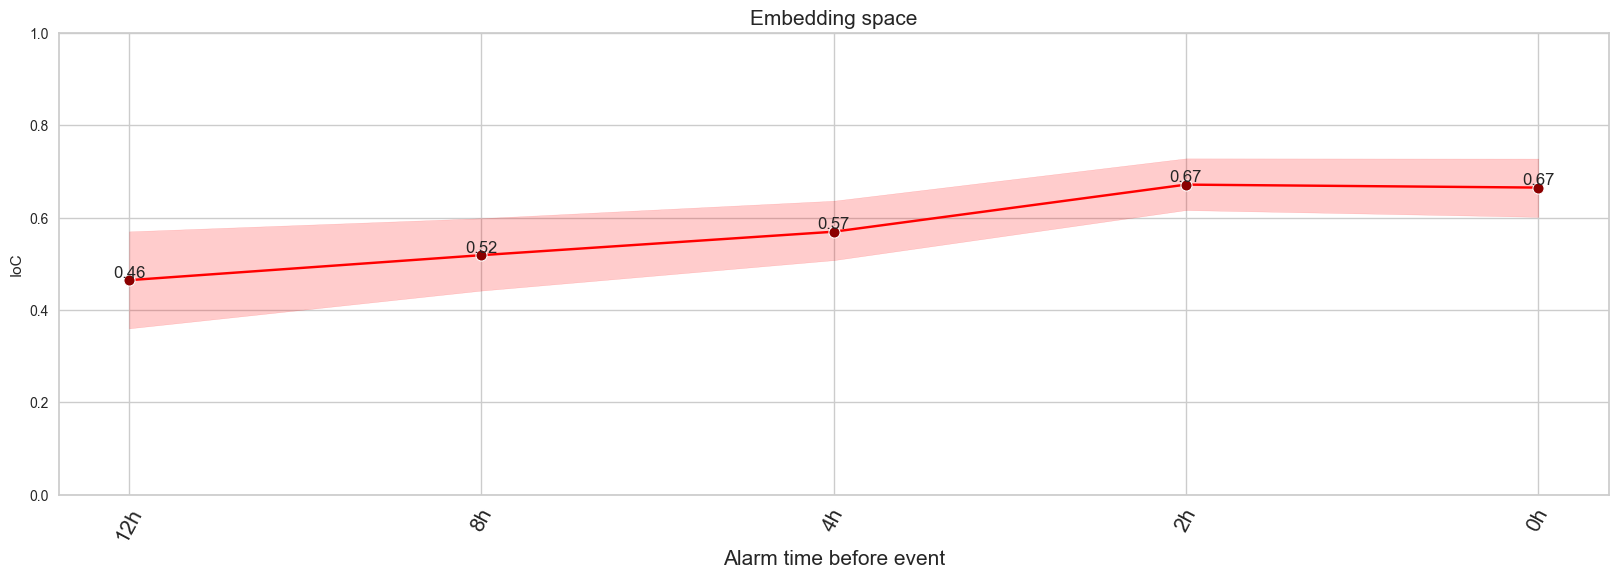

In [67]:
# 각 모델의 예측 결과를 저장하는 데이터프레임 목록 생성
model_predictions = [for_newplot_1, for_newplot_2, for_newplot_3, for_newplot_4, for_newplot_5]
model_names = ['lgbm', 'dt', 'xgboost', 'lr', 'svm']

# 빈 리스트를 만들어 나이 그룹과 해당 그룹의 IOC 값을 저장
age_groups = []
IOC_scores = []
model_labels = []

# 모델 목록을 반복하면서 각 모델에 대한 성능 메트릭 계산
for model_name, predictions in zip(model_names, model_predictions):
    data = predictions[['classes', 'prediction_label', 'alarm_Group']]
    unique_age_groups = ['12h', '8h', '4h',  '2h', '0h']
    # unique_age_groups = sorted(unique_age_groups)
    
    for age_group in unique_age_groups:
        subset = data[data['alarm_Group'] == age_group]
        recall = recall_score(subset['classes'], subset['prediction_label'])
        precision = precision_score(subset['classes'], subset['prediction_label'])
        ioc = IoC(precision, recall, 1.5)
        age_groups.append(age_group)
        IOC_scores.append(recall)
        model_labels.append(model_name)

# 데이터프레임으로 변환
data1 = pd.DataFrame({'alarm_Group': age_groups, 'IOC': IOC_scores, 'Model': model_labels})
plt.figure(figsize=(20, 6))
# 그래프 그리기 (포인트 플롯)
sns.lineplot(data=data1, x='alarm_Group', y='IOC', marker='o', markersize=8, markerfacecolor='darkred', color= 'red')
# sns.lineplot(x=data['time_Group'], y=['1h(428/677)', '2h(367/591)', '4h(397/996)', '8h(773/1745)', '24h(2256/8780)', '2d(2184/23700)', '3d~(1029/34297)'], marker='o', markersize=8, markerfacecolor='red')
plt.xlabel('Alarm time before event', fontsize=15)
plt.ylabel('IoC')
plt.title('Embedding space', fontsize=15)
plt.xticks(rotation=62,fontsize=15)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='upper right')  # 범례 표시

# totalIOC = 0.47769309537780436
# plt.axhline(y=totalIOC, color='r', linestyle='--', label=f'Average IoC(beta=1.5) = {totalIOC:.2f}')
# plt.legend(loc='upper right', fontsize=15)  # 범례 표시
# 각 그룹별로 IOC의 평균값을 계산하고 노출
average_ioc = data1.groupby(['alarm_Group'])['IOC'].mean().reset_index()
for i, row in average_ioc.iterrows():
    x_position = unique_age_groups.index(row['alarm_Group'])
    plt.text(x_position, row['IOC'], f"{row['IOC']:.2f}", ha='center', va='bottom')

plt.show()

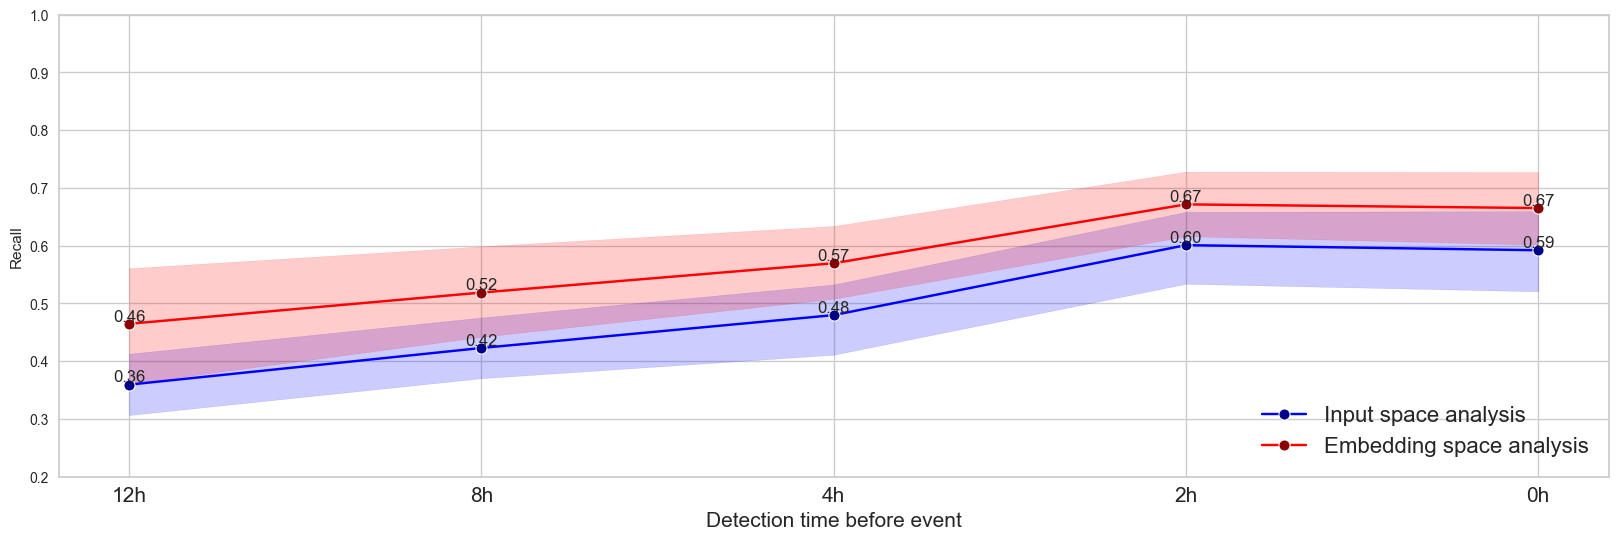

In [79]:
# 각 모델의 예측 결과를 저장하는 데이터프레임 목록 생성
model_predictions = [for_newplot_1_o, for_newplot_2_o, for_newplot_3_o, for_newplot_4_o, for_newplot_5_o]
model_names = ['lgbm', 'dt', 'xgboost', 'lr', 'svm']

# 빈 리스트를 만들어 나이 그룹과 해당 그룹의 IOC 값을 저장
age_groups = []
IOC_scores = []
model_labels = []

# 모델 목록을 반복하면서 각 모델에 대한 성능 메트릭 계산
for model_name, predictions in zip(model_names, model_predictions):
    data = predictions[['classes', 'prediction_label', 'alarm_Group']]
    unique_age_groups = ['12h', '8h', '4h',  '2h', '0h']
    # unique_age_groups = sorted(unique_age_groups)
    
    for age_group in unique_age_groups:
        subset = data[data['alarm_Group'] == age_group]
        recall = recall_score(subset['classes'], subset['prediction_label'])
        precision = precision_score(subset['classes'], subset['prediction_label'])
        ioc = IoC(precision, recall, 1.5)
        age_groups.append(age_group)
        IOC_scores.append(recall)
        model_labels.append(model_name)

# 데이터프레임으로 변환
data2 = pd.DataFrame({'alarm_Group': age_groups, 'IOC': IOC_scores, 'Model': model_labels})
plt.figure(figsize=(20, 6))
# 그래프 그리기 (포인트 플롯)
# sns.lineplot(data=data2, x='alarm_Group', y='IOC', marker='o', markersize=8, markerfacecolor='red')
sns.lineplot(data=data2, x='alarm_Group', y='IOC', marker='o', markersize=8, markerfacecolor='darkblue', color= 'blue', label='Input space analysis')
sns.lineplot(data=data1, x='alarm_Group', y='IOC', marker='o', markersize=8, markerfacecolor='darkred', color= 'red', label='Embedding space analysis')
# sns.lineplot(x=data['time_Group'], y=['1h(428/677)', '2h(367/591)', '4h(397/996)', '8h(773/1745)', '24h(2256/8780)', '2d(2184/23700)', '3d~(1029/34297)'], marker='o', markersize=8, markerfacecolor='red')
plt.xlabel('Detection time before event', fontsize=15)
plt.ylabel('Recall')
# plt.title('Input space', fontsize=15)
plt.xticks(rotation=0,fontsize=15)
plt.ylim(0.2, 1)
plt.grid(True)
plt.legend(loc='lower right',fontsize=16)  # 범례 표시

# totalIOC = 0.47769309537780436
# plt.axhline(y=totalIOC, color='r', linestyle='--', label=f'Average IoC(beta=1.5) = {totalIOC:.2f}')
# plt.legend(loc='upper right', fontsize=15)  # 범례 표시
# 각 그룹별로 IOC의 평균값을 계산하고 노출
average_ioc2 = data2.groupby(['alarm_Group'])['IOC'].mean().reset_index()
for i, row in average_ioc2.iterrows():
    x_position = unique_age_groups.index(row['alarm_Group'])
    plt.text(x_position, row['IOC'], f"{row['IOC']:.2f}", ha='center', va='bottom')
    
average_ioc1 = data1.groupby(['alarm_Group'])['IOC'].mean().reset_index()
for i, row in average_ioc1.iterrows():
    x_position = unique_age_groups.index(row['alarm_Group'])
    plt.text(x_position, row['IOC'], f"{row['IOC']:.2f}", ha='center', va='bottom')
plt.show()

In [80]:
for_newplot_1.groupby('alarm_Group').count()

,Time_since_ICU_admission,Phenylephrine,Dextrose_5%,Norepinephrine,Nitroglycerin,HeparinSodium,Dopamine,Diltiazem,Vasopressin,Phenylephrine (50/250),...,classes,prediction_label,prediction_score_0,prediction_score_1,Age_Group,insurance_Group,gender_Group,ethnicity_Group,time_Group,Time_since_FirstCirc
alarm_Group,,,,,,,,,,,,,,,,,,,,,
0h,408,408,408,408,408,408,408,408,408,408,...,408,408,408,408,408,408,408,408,399,408
2h,796,796,796,796,796,796,796,796,796,796,...,796,796,796,796,796,796,796,796,752,796
4h,1450,1450,1450,1450,1450,1450,1450,1450,1450,1450,...,1450,1450,1450,1450,1450,1450,1450,1450,1388,1450
8h,1238,1238,1238,1238,1238,1238,1238,1238,1238,1238,...,1238,1238,1238,1238,1238,1238,1238,1238,1190,1238
12h,3088,3088,3088,3088,3088,3088,3088,3088,3088,3088,...,3088,3088,3088,3088,3088,3088,3088,3088,3019,3088


In [84]:
for_newplot_1

,Time_since_ICU_admission,Phenylephrine,Dextrose_5%,Norepinephrine,Nitroglycerin,HeparinSodium,Dopamine,Diltiazem,Vasopressin,Phenylephrine (50/250),...,prediction_label,prediction_score_0,prediction_score_1,Age_Group,insurance_Group,gender_Group,ethnicity_Group,time_Group,Time_since_FirstCirc,alarm_Group
126,0.0,-0.0,130.636505,0.0,99.079994,1357.300049,0.0,0.0,-0.0,0.0,...,1,0.2589,0.7411,61-70,Medicare,Male,WHITE,NaN,64.0,NaN
127,0.5,-0.0,130.636505,0.0,99.079994,1357.300049,0.0,0.0,-0.0,0.0,...,1,0.2453,0.7547,61-70,Medicare,Male,WHITE,1h,63.5,NaN
128,1.0,-0.0,94.524132,0.0,99.079994,9452.412109,0.0,0.0,-0.0,0.0,...,1,0.1922,0.8078,61-70,Medicare,Male,WHITE,1h,63.0,NaN
129,1.5,-0.0,94.524132,0.0,99.079994,9452.412109,0.0,0.0,-0.0,0.0,...,1,0.1922,0.8078,61-70,Medicare,Male,WHITE,2h,62.5,NaN
130,2.0,-0.0,94.524132,0.0,99.079994,9452.412109,0.0,0.0,-0.0,0.0,...,1,0.1843,0.8157,61-70,Medicare,Male,WHITE,2h,62.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71779,3.5,0.0,-0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,1,0.2108,0.7892,31-40,Medicare,Male,BLACK/AFRICAN,4h,6.5,4h
72020,0.0,-0.0,-0.000000,0.0,-0.000000,0.000000,0.0,0.0,0.0,0.0,...,1,0.0600,0.9400,41-50,Other,Male,BLACK/AFRICAN AMERICAN,NaN,17.0,12h
72021,0.5,-0.0,-0.000000,0.0,-0.000000,0.000000,0.0,0.0,0.0,0.0,...,1,0.0600,0.9400,41-50,Other,Male,BLACK/AFRICAN AMERICAN,1h,16.5,12h
72022,1.0,-0.0,-0.000000,0.0,-0.000000,0.000000,0.0,0.0,0.0,0.0,...,1,0.0454,0.9546,41-50,Other,Male,BLACK/AFRICAN AMERICAN,1h,16.0,12h
